In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 260 (delta 57), reused 51 (delta 51), pack-reused 171
Receiving objects: 100% (260/260), 53.34 MiB | 24.93 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=af6014941c70672f74786a8695c65a6f5337a38d80f2b1d4e6ff375ed3c5cc08
  Stored in directory: /tmp/pip-ephem-wheel-cache-l5k6mzyk/wheels/55/59/29/0fb1c635652157734

In [2]:
from dul_2021.utils.hw7_utils import *

In [3]:
import numpy as np
import torchvision
import functools
import torch
import torch.utils.data as data
import torch.nn.functional as F
import torch.nn as nn
from tqdm import tqdm_notebook, trange

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



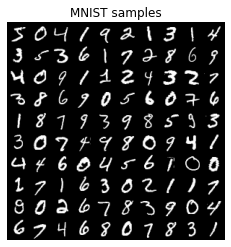

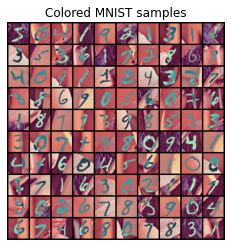

In [5]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [6]:
class ResnetBlock(nn.Module):
    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_b(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_b(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]
        return nn.Sequential(*conv_block)

    def forward(self, x):
        out = x + self.conv_block(x)
        return out

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        super().__init__()
        if type(norm_layer) == functools.partial:  
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers): 
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult), nn.LeakyReLU(0.2, True)]
        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult), nn.LeakyReLU(0.2, True)]
        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)] 
        self.model = nn.Sequential(*sequence)

    def forward(self, inputs):
        return self.model(inputs).squeeze()

In [8]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, 
                 use_dropout=False, n_blocks=3, padding_type='reflect'):
        assert (n_blocks >= 0)
        super().__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d
        model = [nn.ReflectionPad2d(3), nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf), nn.ReLU(True)]
        n_downsampling = 2
        for i in range(n_downsampling): 
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2), nn.ReLU(True)]
        mult = 2 ** n_downsampling
        for i in range(n_blocks): 
            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, 
                                  use_dropout=use_dropout, use_bias=use_bias)]
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2), kernel_size=3, stride=2,
                                         padding=1, output_padding=1, bias=use_bias),
                      norm_layer(int(ngf * mult / 2)), nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, inputs):
        return (self.model(inputs) + 1) / 2

In [9]:
class CycleGAN:
    def __init__(self, X_depth, Y_depth, n_filter, lr, lmbda):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.g_X = Generator(Y_depth, X_depth).to(self.device)
        self.g_Y = Generator(X_depth, Y_depth).to(self.device)
        self.d_X = Discriminator(X_depth).to(self.device)
        self.d_Y = Discriminator(Y_depth).to(self.device)
        self.g_optimizer = torch.optim.Adam(list(self.g_X.parameters()) + list(self.g_Y.parameters()), lr=lr)
        self.d_optimizer = torch.optim.Adam(list(self.d_X.parameters()) + list(self.d_Y.parameters()), lr=lr / 2)
        self.lmbda = lmbda
        self.l1_loss = torch.nn.L1Loss()

    def train_d(self, x, y):
        x, y = x.to(self.device).float(), y.to(self.device).float()
        dx_loss = (self.d_X(x) - 1) ** 2 + self.d_X(self.g_X(y).detach()) ** 2
        dy_loss = (self.d_Y(y) - 1) ** 2 + self.d_Y(self.g_Y(x).detach()) ** 2
        loss = torch.mean(dx_loss + dy_loss)
        self.d_optimizer.zero_grad()
        loss.backward()
        self.d_optimizer.step()
        return loss.cpu().item()

    def train_g(self, x, y):
        x, y = x.to(self.device).float(), y.to(self.device).float()
        self.freeze(self.d_X)
        self.freeze(self.d_Y)
        dx_loss = torch.mean((self.d_X(self.g_X(y)) - 1) ** 2)
        dy_loss = torch.mean((self.d_Y(self.g_Y(x)) - 1) ** 2)
        cycle_loss1 = self.l1_loss(self.g_X(self.g_Y(x)), x)
        cycle_loss2 = self.l1_loss(self.g_Y(self.g_X(y)), y)
        cycle_loss = cycle_loss1 + cycle_loss2
        loss = dx_loss + dy_loss + self.lmbda * cycle_loss
        self.g_optimizer.zero_grad()
        loss.backward()
        self.g_optimizer.step()
        self.reset(self.d_X)
        self.reset(self.d_Y)
        return loss.cpu().item()

    def translate(self, inputs, source_distribution):
        with torch.no_grad():
            if source_distribution == "X":
                self.g_Y.eval()
                x = inputs.to(self.device).float()
                y = self.g_Y(x)
                return y.permute(0, 2, 3, 1).cpu().numpy()
            else:
                self.g_X.eval()
                y = inputs.to(self.device).float()
                x = self.g_X(y)
                return x.permute(0, 2, 3, 1).cpu().numpy()

    def reconstruction(self, inputs, source_distribution):
        self.g_X.eval()
        self.g_Y.eval()
        with torch.no_grad():
            if source_distribution == "X":
                x = inputs.to(self.device).float()
                y = self.g_Y(x)
                x_ = self.g_X(y)
                return x_.permute(0, 2, 3, 1).cpu().numpy()
            else:
                y = inputs.to(self.device).float()
                x = self.g_X(y)
                y_ = self.g_Y(x)
                return y_.permute(0, 2, 3, 1).cpu().numpy()

    def freeze(self, sub_model):
        for param in sub_model.parameters():
            param.requires_grad = False

    def reset(self, sub_model):
        for param in sub_model.parameters():
            param.requires_grad = True

In [10]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    lr = 2e-4
    batch_size = 256
    k = 1
    lmbda = 10
    epochs = 20
    n_filters = 32
    
    model = CycleGAN(1, 3, n_filters, lr, lmbda)
    mnist_loader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)
    cmnist_loader = torch.utils.data.DataLoader(cmnist_data, batch_size=batch_size, shuffle=True)
    x_samples = torch.from_numpy(mnist_data[0:20])
    y_samples = torch.from_numpy(cmnist_data[0:20])
    
    for i in range(epochs):
        j = 0
        for x, y in zip(mnist_loader, cmnist_loader):
            g_loss = model.train_g(x, y)
            if j % k == 0:
                d_loss = model.train_d(x, y)
            j = j + 1
            
    x_translate = model.translate(x_samples, "X")
    x_reconstruct = model.reconstruction(x_samples, "X")
    y_translate = model.translate(y_samples, "Y")
    y_reconstruct = model.reconstruction(y_samples, "Y")
    x_samples = x_samples.permute(0, 2, 3, 1).numpy()
    y_samples = y_samples.permute(0, 2, 3, 1).numpy()
    return x_samples, x_translate, x_reconstruct, y_samples, y_translate, y_reconstruct

## Results

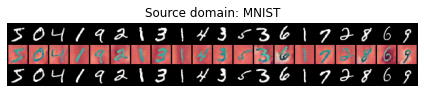

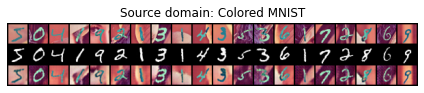

In [13]:
b5_save_results(b5)